**1- Import all the libraries you may need here:**

In [ ]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import glob
import shutil

import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from torchvision.models import vgg19_bn
from torch import optim
import seaborn as sns

random.seed(0)
device = "cuda:0" if torch.cuda.is_available() else "cpu"

Clone dataset and read images

In [ ]:
!git clone https://github.com/UCSD-AI4H/COVID-CT
!unzip COVID-CT/Images-processed/CT_COVID.zip
!unzip COVID-CT/Images-processed/CT_NonCOVID.zip
covid_files_path = 'CT_COVID/'
covid_files      = [os.path.join(covid_files_path, x) for x in os.listdir(covid_files_path)]
non_covid_files_path = 'CT_NonCOVID/'
non_covid_files      = [os.path.join(non_covid_files_path, x) for x in os.listdir(non_covid_files_path)]

Cloning into 'COVID-CT'...
remote: Enumerating objects: 5463, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 5463 (delta 0), reused 0 (delta 0), pack-reused 5459
Receiving objects: 100% (5463/5463), 1.09 GiB | 30.58 MiB/s, done.
Resolving deltas: 100% (360/360), done.
Checking out files: 100% (1048/1048), done.
Archive:  COVID-CT/Images-processed/CT_COVID.zip
   creating: CT_COVID/
  inflating: CT_COVID/2020.03.01.20029769-p21-73_1%1.png  
   creating: __MACOSX/
   creating: __MACOSX/CT_COVID/
  inflating: __MACOSX/CT_COVID/._2020.03.01.20029769-p21-73_1%1.png  
  inflating: CT_COVID/Recurrence-of-positive-SARS-CoV-2-RNA-in-C_2020_International-Journal-of-Inf-p1-21%1.png  
  inflating: __MACOSX/CT_COVID/._Recurrence-of-positive-SARS-CoV-2-RNA-in-C_2020_International-Journal-of-Inf-p1-21%1.png  
  inflating: CT_COVID/2020.03.12.20034686-p17-91-4.png  
  inflating: __MACOSX/CT_COVID/._2020.03.12.20034686-p17-91-4.png  
  inf

In [ ]:
def plot_3random_img(files):
  images =  [cv2.imread(x) for x in random.sample(files, 3)] # reading 3 random Samples from files

  plt.figure(figsize=(20,15))
  for i, img in enumerate(images):
      plt.subplot(len(images), 3, i + 1)
      plt.axis('off')
      plt.imshow(img)

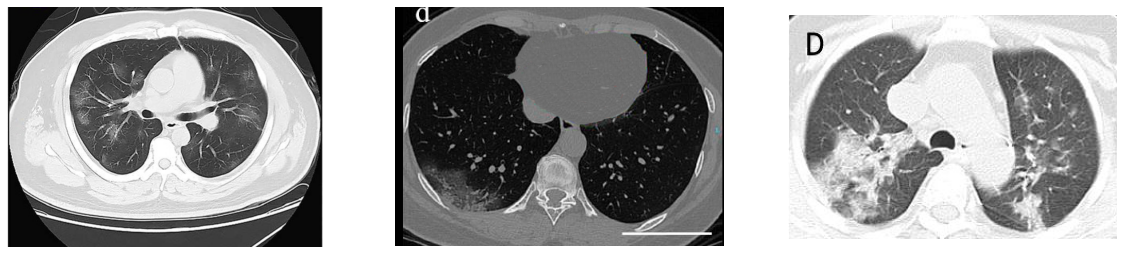

In [ ]:
plot_3random_img(covid_files) #positive Covid19 samples

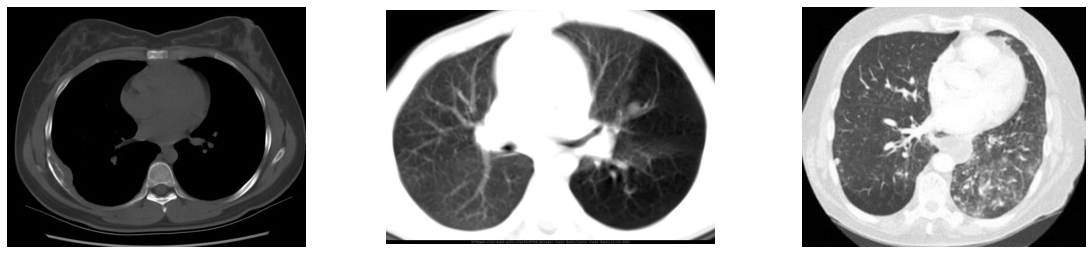

In [ ]:
plot_3random_img(non_covid_files) #non-Covid19 samples

The dataset is divided into three splits: the train set (425 examples), validation set (118 examples), and the test set (203 examples). Information for this split has been provided in the folder Data-split folder.  This folder contains text files which explain what files belong to each split.

We write a function to read these files and put them into a list of strings:

In [ ]:
def read_txt(txt_path):
    with open(txt_path) as f:
        lines = f.readlines()
    txt_data = [line.strip() for line in lines]
    return txt_data

We then create the COVIDCTDataset class which basically subclasses the torch.utils.data.Dataset class:

In [ ]:
class CovidCTDataset(Dataset):
    def __init__(self, root_dir, classes, covid_files, non_covid_files, transform=None):
        self.root_dir = root_dir
        self.classes = classes
        self.files_path = [non_covid_files, covid_files]
        self.image_list = []

        # read the files from data split text files
        covid_files = read_txt(covid_files)
        non_covid_files = read_txt(non_covid_files)

        # combine the positive and negative files into a cummulative files list
        for cls_index in range(len(self.classes)):
            
            class_files = [[os.path.join(self.root_dir, self.classes[cls_index], x), cls_index] \
                            for x in read_txt(self.files_path[cls_index])]
            self.image_list += class_files
                
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        path = self.image_list[idx][0]
        
        # Read the image
        image = Image.open(path).convert('RGB')
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)

        label = int(self.image_list[idx][1])

        data = {'img':   image,
                'label': label,
                'paths' : path}

        return data

## Preprocessing

In [ ]:
train_transformer = transforms.Compose([transforms.Resize(256),
                                        transforms.RandomResizedCrop((224),scale=(0.5, 1.0)),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])])

In [ ]:
val_transformer = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])])

## Training

In [ ]:
batchsize = 8

trainset = CovidCTDataset(root_dir='/content/',
                          classes = ['CT_NonCOVID', 'CT_COVID'],
                          covid_files='COVID-CT/Data-split/COVID/trainCT_COVID.txt',
                          non_covid_files='/content/COVID-CT/Data-split/NonCOVID/trainCT_NonCOVID.txt',  
                          transform = train_transformer)
valset = CovidCTDataset(root_dir='/content/',
                          classes = ['CT_NonCOVID', 'CT_COVID'],
                          covid_files='COVID-CT/Data-split/COVID/valCT_COVID.txt',
                          non_covid_files = '/content/COVID-CT/Data-split/NonCOVID/valCT_NonCOVID.txt',
                          transform = val_transformer)
testset = CovidCTDataset(root_dir='/content/',
                          classes = ['CT_NonCOVID', 'CT_COVID'],
                          covid_files='COVID-CT/Data-split/COVID/testCT_COVID.txt',
                          non_covid_files='/content/COVID-CT/Data-split/NonCOVID/testCT_NonCOVID.txt',
                          transform = val_transformer)

train_loader = DataLoader(trainset, batch_size=batchsize, drop_last=False, shuffle=True)
val_loader = DataLoader(valset, batch_size=batchsize, drop_last=False, shuffle=False)
test_loader = DataLoader(testset, batch_size=batchsize, drop_last=False, shuffle=False)

In [ ]:
#CODE HERE

def calculating_metrics(model, test_loader, plot_roc_curve = False):

    # Evaluation the pytorch model with val_loader
    model.eval()

    # For saving losses of (log cross entropy) function loss 
    # Each iteration (Adding them together)
    val_loss = 0

    # For saving number of correctly predicted output by the model
    val_correct = 0

    # Using cross entropy loss for classification (Final layer is a linear with two neurons)
    # That's why we use "CrossEntropyLoss()" instead of "BCEloss()"
    # Note: It is actually "Softmax + Cross entropy loss"
    # Softmax will be used for the output for classification purpose
    criterion = nn.CrossEntropyLoss()

    # For Bookkeeping
    # self.long() is equivalent to self.to(torch.int64)
    score_list  = torch.Tensor([]).to(device)
    pred_list   = torch.Tensor([]).to(device).long()
    target_list = torch.Tensor([]).to(device).long()
    path_list   = []


    for iter, data in enumerate(test_loader):

        # Converting img data into single channel data
        image, target = data['img'].to(device), data['label'].to(device)
        paths = data['paths']
        path_list.extend(paths)

        # Forward pass for the model
        with torch.no_grad():
            output = model(image)
        
        # Calculating loss
        val_loss += criterion(output, target.long()).item()

        # Number of correctly classified predicted outputs
        pred = output.argmax(dim=1, keepdim=True)
        val_correct += pred.eq(target.long().view_as(pred)).sum().item()

        # We pass the output (final linear layer with one having 2 neurons) through softmax 
        score_list   = torch.cat([score_list, nn.Softmax(dim = 1)(output)[:,1].squeeze()]) 
        pred_list    = torch.cat([pred_list, pred.squeeze()])
        target_list  = torch.cat([target_list, target.squeeze()])
        
    
    classification_metrics = classification_report(target_list.tolist(), pred_list.tolist(),
                                                   target_names = ['CT_NonCOVID', 'CT_COVID'],
                                                   output_dict= True,
                                                   )
        

    # sensitivity is the recall of the positive class
    sensitivity = classification_metrics['CT_COVID']['recall']
        
    # specificity is the recall of the negative class 
    specificity = classification_metrics['CT_NonCOVID']['recall']
        
    # accuracy
    acc = classification_metrics['accuracy']
        
    # confusion matrix
    con_matrix = confusion_matrix(target_list.tolist(), pred_list.tolist())
        
    # roc score
    roc_score = roc_auc_score(target_list.tolist(), score_list.tolist())

    # plot the roc curve
    if plot_roc_curve:
        false_prate, true_prate, _ = roc_curve(target_list.tolist(), score_list.tolist())
        plt.plot(false_prate, true_prate, label = "Area under ROC = {:.4f}".format(roc_score))
        plt.legend(loc = 'best')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
            
        
    # put together values
    metrics_dict = {"Accuracy": acc,
                    "Sensitivity": sensitivity,
                    "Specificity": specificity,
                    "Roc_score"  : roc_score, 
                    "Confusion Matrix": con_matrix,
                    "Validation Loss": val_loss / len(test_loader)}
        
    # A dictionary of all the metrics we want    
    return metrics_dict

In [ ]:
model = vgg19_bn(pretrained=True)

We then replace its final linear layer with one having 2 neurons at its output, and perform transfer learning over our dataset.

In [ ]:
model.classifier[6] = nn.Linear(4096, 2)
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
# Hyperparameters
learning_rate = 0.01
momentum = 0.9


optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = momentum)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 8, gamma = 0.1)

In [ ]:
best_model = model #initialization
best_validation_acc = 0

criterion = nn.CrossEntropyLoss()

for epoch in range(40):
    model.train()
    train_loss = 0
    train_correct = 0

    for iter, data in enumerate(train_loader):
        image, target = data['img'].to(device), data['label'].to(device)

        #Forward pass
        output = model(image)

        #Calculating loss
        ## divide the loss by 8 since we are adding updates for 8 iterations
        loss = criterion(output, target.long()) / 8  
        train_loss += loss.item()

        #Backward pass
        loss.backward()

        # Gradient Update --> updating every 8 iteration
        if iter % 8 == 0:
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
            


        # Calculate the number of correctly classified examples
        pred = output.argmax(dim=1, keepdim=True)
        train_correct += pred.eq(target.long().view_as(pred)).sum().item()

    # Checking the performance metrics for every 5 epoch
    if epoch == 0 or (epoch + 1) % 5 == 0:
        metrics_dict = calculating_metrics(model, val_loader)
        print('------------------------------- Epoch {}/{} ----------------------------------'.format(epoch+1, 40))
        print("Accuracy \t {:.3f}".format(metrics_dict['Accuracy']))
        print("Sensitivity \t {:.3f}".format(metrics_dict['Sensitivity']))
        print("Specificity \t {:.3f}".format(metrics_dict['Specificity']))
        print("Area Under ROC \t {:.3f}".format(metrics_dict['Roc_score']))
        print("Val Loss \t {}".format(metrics_dict["Validation Loss"]))
        print("------------------------------------------------------------------------------")
        print('\n')

    # Save the model with best validation accuracy
    if metrics_dict['Accuracy'] > best_validation_acc:
        torch.save(model, "best_model.pkl")
        best_validation_acc = metrics_dict['Accuracy']
         

------------------------------- Epoch 1/40 ----------------------------------
Accuracy 	 0.568
Sensitivity 	 0.283
Specificity 	 0.862
Area Under ROC 	 0.628
Val Loss 	 0.9522139936685562
------------------------------------------------------------------------------


------------------------------- Epoch 5/40 ----------------------------------
Accuracy 	 0.822
Sensitivity 	 0.833
Specificity 	 0.810
Area Under ROC 	 0.862
Val Loss 	 0.6335414328301946
------------------------------------------------------------------------------


------------------------------- Epoch 10/40 ----------------------------------
Accuracy 	 0.754
Sensitivity 	 0.717
Specificity 	 0.793
Area Under ROC 	 0.852
Val Loss 	 0.9092373985991192
------------------------------------------------------------------------------


------------------------------- Epoch 15/40 ----------------------------------
Accuracy 	 0.720
Sensitivity 	 0.600
Specificity 	 0.845
Area Under ROC 	 0.840
Val Loss 	 0.9500029095758994
---

## Testing

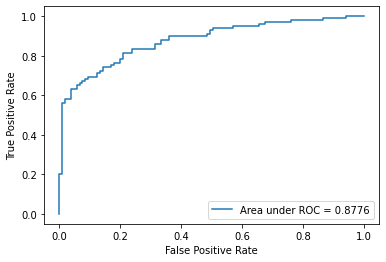

---------------------- Test Performance --------------------------------------
Accuracy 	 0.798
Sensitivity 	 0.816
Specificity 	 0.781
Area Under ROC 	 0.878
------------------------------------------------------------------------------


In [ ]:
model = torch.load("best_model.pkl")

metrics_dict = calculating_metrics(model, test_loader, plot_roc_curve = True)
print('---------------------- Test Performance --------------------------------------')
print("Accuracy \t {:.3f}".format(metrics_dict['Accuracy']))
print("Sensitivity \t {:.3f}".format(metrics_dict['Sensitivity']))
print("Specificity \t {:.3f}".format(metrics_dict['Specificity']))
print("Area Under ROC \t {:.3f}".format(metrics_dict['Roc_score']))
print("------------------------------------------------------------------------------")

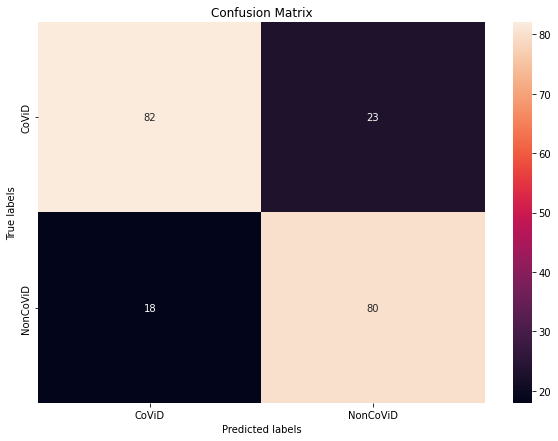

In [ ]:
con_matrix = metrics_dict["Confusion Matrix"]

fig = plt.figure()
fig.set_size_inches(10, 7)
ax= plt.subplot()
sns.heatmap(con_matrix, annot=True, ax = ax); #annot=True to annotate cells


ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['CoViD', 'NonCoViD']); ax.yaxis.set_ticklabels(['CoViD', 'NonCoViD']);